In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import skew, kurtosis
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import joblib
from skimage.feature import local_binary_pattern

In [2]:
data_dir = r'C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\Vegetation_Encroachment_Data\VegetationEncroachmentData-main\VegetationEncroachmentData-main'
high_dir = os.path.join(data_dir, 'high_dense')   # Folder containing high-density patches
low_dir  = os.path.join(data_dir, 'low_dense')     # Folder containing low-density patches

print("High density folder exists:", os.path.exists(high_dir))
print("Low density folder exists:", os.path.exists(low_dir))

High density folder exists: True
Low density folder exists: True


In [3]:
def extract_features(image):
    """
    Extracts features from a 32x32 image patch.
    Features include:
      - Color moments: mean, standard deviation, skewness, kurtosis for each RGB channel.
      - Texture features from the gray-level co-occurrence matrix (GLCM): contrast, dissimilarity,
        homogeneity, energy, and correlation.
    """
    # Convert image from BGR (OpenCV default) to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    features = []
    
    # Calculate color moments for each channel (R, G, B)
    for i in range(3):
        channel = image_rgb[:, :, i].flatten()
        features.append(np.mean(channel))
        features.append(np.std(channel))
        features.append(skew(channel))
        features.append(kurtosis(channel))
  
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    
    # Extract GLCM features
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    
    features.extend([contrast, dissimilarity, homogeneity, energy, correlation])

    lbp = local_binary_pattern(gray, P=8, R=1, method='default')
    lbp_sum = lbp.sum()
    features.append(lbp_sum)
    
    return features


In [4]:
def sliding_window(image, window_size=(32, 32), step_size=16):
    """
    Slide a window across the image and yield patches along with their top-left coordinates.
    :param image: Input image.
    :param window_size: Tuple of (height, width) for each patch.
    :param step_size: Number of pixels to move the window in both directions.
    """
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            patch = image[y:y + window_size[1], x:x + window_size[0]]
            yield (x, y, patch)

In [5]:
# Prepare lists for feature vectors and labels.
X = []  # Feature vectors
y = []  # Labels (1 for high-density, 0 for low-density)

# Process high-density patches (label = 1)
if os.path.exists(high_dir):
    for file in os.listdir(high_dir):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(high_dir, file)
            img = cv2.imread(img_path)
            if img is not None:
                feat = extract_features(img)
                X.append(feat)
                y.append(1)
                
# Process low-density patches (label = 0)
if os.path.exists(low_dir):
    for file in os.listdir(low_dir):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(low_dir, file)
            img = cv2.imread(img_path)
            if img is not None:
                feat = extract_features(img)
                X.append(feat)
                y.append(0)

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

Feature matrix shape: (12351, 18)
Labels shape: (12351,)


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 9880
Testing samples: 2471


In [7]:
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [8]:
y_pred = svm_clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1236
           1       0.98      0.99      0.98      1235

    accuracy                           0.98      2471
   macro avg       0.98      0.98      0.98      2471
weighted avg       0.98      0.98      0.98      2471

Confusion Matrix:
[[1207   29]
 [  15 1220]]


In [9]:
model_filename = 'svm_vegetation_model.pkl'
scaler_filename = 'scaler.pkl'
joblib.dump(svm_clf, model_filename)
joblib.dump(scaler, scaler_filename)
print("Model and scaler saved.")


Model and scaler saved.


first_pred: 0
First block dark ratio: 0.004669189453125
First block prediction (0: low-density, 1: high-density): 0
Classified full image saved in results\classified_full_image_20250305_150417.png


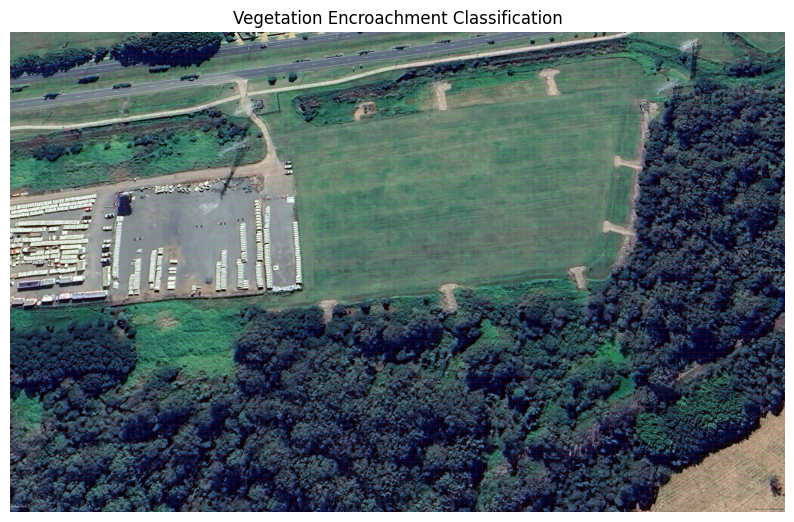

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import datetime

# Path to the full satellite image (replace with your image file)
full_image_path = r'C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\Vegetation_Encroachment_Data\Test_Images\Satellite_Image_Google_Transmission_.jpg'
full_image = cv2.imread(full_image_path)
if full_image is None:
    print("Full satellite image not found. Please check the file path.")
else:
    dark_threshold_value = 65
    dark_ratio_threshold = 0.30  

    first_block = full_image[0:256, 256:384]  
    gray = cv2.cvtColor(first_block, cv2.COLOR_BGR2GRAY)
    total_pixels = gray.size
    dark_pixels = (gray < dark_threshold_value).sum()
    dark_ratio = dark_pixels / total_pixels
    
    if dark_ratio > dark_ratio_threshold:
        first_pred = 1  
    else:
        feat_first = extract_features(first_block)
        feat_first_scaled = scaler.transform([feat_first])
        first_pred = svm_clf.predict(feat_first_scaled)[0]
        print("first_pred:",first_pred)
    
    print("First block dark ratio:", dark_ratio)
    print("First block prediction (0: low-density, 1: high-density):", first_pred)
   
    output_image = full_image.copy()
    
    for (x, y, patch) in sliding_window(full_image, window_size=(128, 128), step_size=64):
        if patch.shape[0] != 128 or patch.shape[1] != 128:
            continue 
        
        gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
        total_pixels = gray_patch.size
        dark_pixels = (gray_patch < dark_threshold_value).sum()
        dark_ratio = dark_pixels / total_pixels
        
        if dark_ratio > dark_ratio_threshold:
            pred = 1
        else:
            feat = extract_features(patch)
            feat_scaled = scaler.transform([feat])
            pred = svm_clf.predict(feat_scaled)[0]
        
        color = (0, 255, 0) if pred == 0 else (0, 0, 255)
        cv2.rectangle(output_image, (x, y), (x + 128, y + 128), color, 1)
    
    results_dir = 'results'
    os.makedirs(results_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    result_image_path = os.path.join(results_dir, f'classified_full_image_{timestamp}.png')
    cv2.imwrite(result_image_path, output_image)
    print(f"Classified full image saved in {result_image_path}")
    
    output_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(output_rgb)
    plt.title("Vegetation Encroachment Classification")
    plt.axis("off")
    plt.show()


first_pred: 0
First block dark ratio: 0.05902099609375
First block prediction (0: low-density, 1: high-density): 0
Classified full image saved in results\classified_full_image_20250305_153035.png


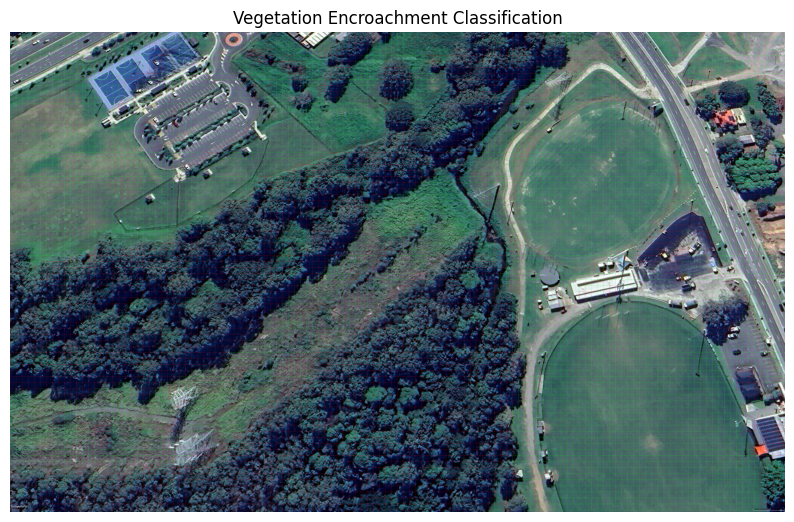

In [21]:
import os
import cv2
import matplotlib.pyplot as plt
import datetime

# Path to the full satellite image (replace with your image file)
full_image_path = r'C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\Vegetation_Encroachment_Data\Test_Images\Satellite_Image_Google_Transmission_5.jpg'
full_image = cv2.imread(full_image_path)
if full_image is None:
    print("Full satellite image not found. Please check the file path.")
else:
    dark_threshold_value = 70  
    dark_ratio_threshold = 0.30

    first_block = full_image[0:256, 256:384]  
    gray = cv2.cvtColor(first_block, cv2.COLOR_BGR2GRAY)
    total_pixels = gray.size
    dark_pixels = (gray < dark_threshold_value).sum()
    dark_ratio = dark_pixels / total_pixels
    
    if dark_ratio > dark_ratio_threshold:
        first_pred = 1
        print("Ram")  
    else:
        feat_first = extract_features(first_block)
        feat_first_scaled = scaler.transform([feat_first])
        first_pred = svm_clf.predict(feat_first_scaled)[0]
        print("first_pred:",first_pred)
    
    print("First block dark ratio:", dark_ratio)
    print("First block prediction (0: low-density, 1: high-density):", first_pred)
   
    output_image = full_image.copy()
    
    for (x, y, patch) in sliding_window(full_image, window_size=(128, 128), step_size=64):
        if patch.shape[0] != 128 or patch.shape[1] != 128:
            continue 
        
        gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
        total_pixels = gray_patch.size
        dark_pixels = (gray_patch < dark_threshold_value).sum()
        dark_ratio = dark_pixels / total_pixels
        
        if dark_ratio > dark_ratio_threshold:
            pred = 1
        else:
            feat = extract_features(patch)
            feat_scaled = scaler.transform([feat])
            pred = svm_clf.predict(feat_scaled)[0]
        
        color = (0, 255, 0) if pred == 0 else (0, 0, 255)
        cv2.rectangle(output_image, (x, y), (x + 128, y + 128), color, 1)
    
    results_dir = 'results'
    os.makedirs(results_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    result_image_path = os.path.join(results_dir, f'classified_full_image_{timestamp}.png')
    cv2.imwrite(result_image_path, output_image)
    print(f"Classified full image saved in {result_image_path}")
    
    output_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(output_rgb)
    plt.title("Vegetation Encroachment Classification")
    plt.axis("off")
    plt.show()
